In [3]:
import jax.numpy as np
import tree_math
import dataclasses

from jaxsnn.base import funcutils
from jaxsnn.base import implicit
from jaxsnn.tree_solver import ArrayLike, tree_solve, tree_matmul


In [4]:
@tree_math.struct
class NeuronState:
    v: ArrayLike
    I: ArrayLike

@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
  d : ArrayLike
  u : ArrayLike
  p : ArrayLike

  def explicit_terms(self, state):
    return NeuronState(
      v = state.I,
      I = -20*state.I
    )

  def implicit_terms(self, state):
    return NeuronState(
      v = tree_matmul(self.d, self.u, self.p, state.v),
      I = np.zeros_like(state.I)
    )

  def implicit_solve(self, state, step_size):
    return NeuronState(
      v = tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
      I = state.I
    )

In [5]:
N = 20
dt =1e-2
inner_steps=1
outer_steps=2000
time = dt * inner_steps * (1 + np.arange(outer_steps))


equation = MultiCompartmentNeuronModel(
    d = -2*np.ones(N),
    u = np.ones(N-1),
    p = np.arange(-1,N,1)
)

initial_state = NeuronState(
    v = np.zeros(N),
    I = np.concatenate((np.array([1.0, 0.0, 0.0, 0.0]), np.zeros(N-4)))
)

semi_implicit_step = implicit.crank_nicolson_rk2(equation, dt)
integrator = funcutils.trajectory(
            funcutils.repeated(semi_implicit_step, inner_steps), outer_steps)
_, actual = integrator(initial_state)

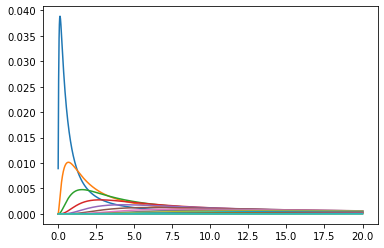

In [6]:
import matplotlib.pyplot as plt

plt.plot(time, actual.v)
plt.show()